# Lecture 19: Unsupervised Learning

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/) <-- missing link

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2022-02-24 16:22:52


## Unsupervised Learning

The majority of data is unlabeled: we have the input features $\mathbf{X}$, but not the labels $\mathbf{y}$.

Imagine that you want to detect defective items on a manufacturing line. You can collect images of the  items on the  manufacturing line easily and automatically, but if you want to train a classifier to predict whether an item is defective or not, you will need to label every image.

This labelling generally requires human experts to sit down and go through the images by hand, which is time consuming, tedious, and prone to errors. As a result, the labelling is often only done on a small subset of the available images.

With unsupervised learning, you do not need labelled data!

## Clustering

*Clustering* is the task of identifying similar instances and assigning them to *clusters*, or groups of similar instances.

Consider the Iris dataset, which classifies each instance into one of three classes:

In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's plot the petal width against the petal length, both with and without different markers for the classes:

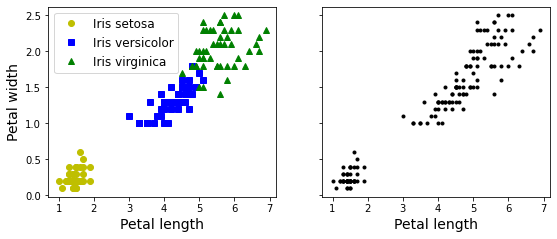

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

When the instances are plotted without different markers to differentiate the classes, as in the figure on the right, it is not obvious that the upper-right cluster is composed of two distinct sub-clusters.

There is no universal definition of what a cluster is. It depends on the context: different algorithms will capture different kinds of clusters.

Some algorithms look for instances centered around a particular point, called a *centroid*. Others look for continuous regions of densely packed instances.

We'll look at two popular clustering algorithms, K-Means and DBSCAN.

## K-Means

K-Means is a simple algorithm, cable of performing clustering very quickly and efficiently, often in only a few iterations.

The K-Means algorithm divides a set of $m$ instances $\mathbf{X}$ (from $\mathbf{x}_1$ to $\mathbf{x}_m$) into $k$ clusters $\textbf{S} = \{S_1, S_2, ..., S_k\}$, each described by their mean $\mathbf{\mu}_i$ (from $\mathbf{\mu}_1$ to $\mathbf{\mu}_k$) so as to minimise to minimise the **inertia**, or the **within-cluster sum of squares**. This is given by:

$$\underset{\textbf{S}}{\arg\min} \sum_{i=1}^{k} \sum_{\textbf{x} \in S_i} \lVert \mathbf{x} - \mathbf{\mu}_i \rVert^2$$

The algorithm consists of the following steps:

- First, initialise $k$ centroids.
- Then, repeat these two steps until convergence (i.e. until the centroids stop moving):
    - Assign each instance to the closest centroid.
    - Create new centroids by taking the mean of all the instances assigned to each centroid.

Let's generate some blobs to use as a dataset, and run the K-Means algorithm for 1, 2, and 3 iterations to see how the centroids move around:

In [5]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]]
)

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

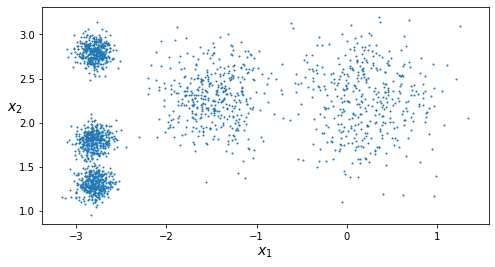

In [7]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

By default, the `KMeans` class in Scikit-Learn applies an optimised algorithm by default. To get the original K-Means algorithm you must set `init="random"`, `n_init=1`, and `algorithm="full"`.

Note that you have to specify the number of clusters $k$:

In [8]:
from sklearn.cluster import KMeans

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

In [9]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
        
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
        
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

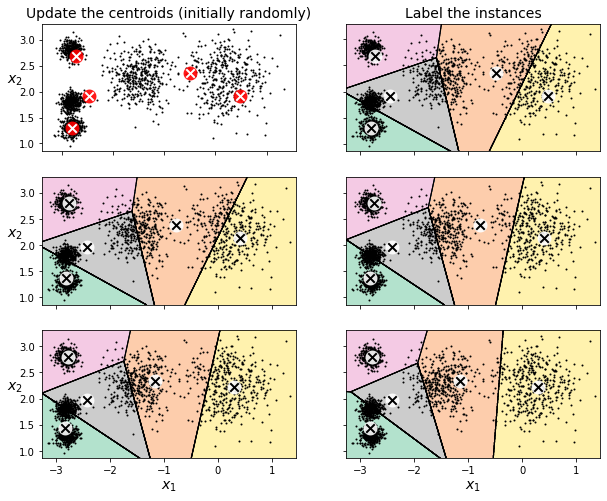

In [10]:
plt.figure(figsize=(10, 8))
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)
plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)
plt.show()

### Accelerated K-Means

An important improvement to the K-Means algorithm was proposed in a [2003 paper by Charles Elkan](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf). It accelerates the algorithm by avoiding many unnecessary distance calculations, and by exploiting the triangle inequality (i.e., that a straight line is always the shortest distance between two points).

The `KMeans` class in Scikit-Learn uses this algorithm by default.

Let’s train an accelerated K-Means clusterer on the blob dataset:

In [11]:
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

Each instances predicted label is the index of the assigned cluster, **not** the class label as in classification:

In [12]:
y_pred

array([2, 4, 1, ..., 0, 1, 4], dtype=int32)

The `KMeans` object preserves the labels of the instances it was trained on:

In [13]:
y_pred is kmeans.labels_

True

We can look at the 5 centroids that the algorithm found, and assign new instances to the cluster whose centroid is closest:

In [14]:
kmeans.cluster_centers_

array([[-2.79290307,  2.79641063],
       [ 0.20667809,  2.25769931],
       [-2.80037642,  1.30082566],
       [-1.46893704,  2.28372774],
       [-2.80389616,  1.80117999]])

In [15]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 0, 0], dtype=int32)

Let's plot the decision boundaries:

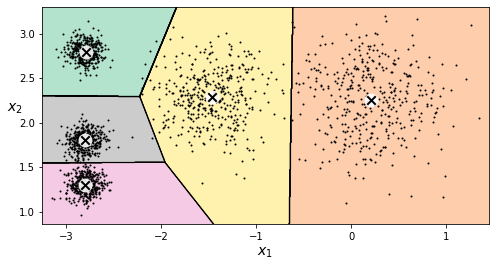

In [16]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

The majority of the clusters were assigned to the appropriate cluster, but a few instances were probably mislabeled (especially near the boundary between the top-left and central clusters).

### Hard vs Soft clustering

Instead of assigning each instance to a single cluster, called *hard clustering*, we can give each instance a score per cluster, which is called *soft clustering*.

You can use the `transform()` method of the `KMeans` class to measure the (euclidian) distance from each instance to every centroid.

If you have a high-dimensionality dataset, then this can be used as a form of efficeient dimensionality reduction to a $k$-dimensional dataset:

In [17]:
kmeans.transform(X_new)

array([[2.9042344 , 0.33034038, 2.88633901, 1.49608739, 2.81093633],
       [5.84739223, 2.80518382, 5.84236351, 4.47793476, 5.80730058],
       [0.29040966, 3.29147303, 1.71086031, 1.69032533, 1.21475352],
       [0.36159148, 3.21581933, 1.21567622, 1.54626242, 0.72581411]])

### Centroid initialization methods

If you know approximately where the centroids should be, then you can set the `init` hyperparameter to a numpy array containing the list of centroids and `n_init=1`:

In [18]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
y_pred = kmeans.fit_predict(X)

Another method is to run the algorithm multiple times with different random initialisations and keep the best one. This is done by setting the `n_init` hyperparameter: by default `n_init=10`.

Scikit-Learn compares the inertia from the different runs and keeps the model with the lowest inertia.

You can access the `kMeans` class's inertai via the `inertia_` attribute:

In [19]:
kmeans.inertia_

211.5985372581684

Scikit-Learn uses the convention that a larger *score* means a better model. So the `score()` method returns the negative intertia:

In [20]:
kmeans.score(X)

-211.59853725816836

By default, the Scikit-Learn `KMeans` class uses the *K-Means++* initialisation method that was intoduced in a [2006 paper by David Arthur and Sergei Vassilvitskii](https://scholar.google.com/scholar?q=kmeans%2B%2B%3A+The+advantages+of+careful+seeding+author%3Aarthur). This method tends to select centroids that are distant from each other, and makes the K-Means algorithm less likely to converge to a suboptimal solution:

- Take one centroid, $\mathbf{c}_1$, chosen uniformly at random from the dataset.
- Take a new centroid, $\mathbf{c}_i$, choosing an instance $\mathbf{x}_i$ with probability $D(\mathbf{x}_i)^2 / \sum_{j=1}^{m} D(\mathbf{x}_i)^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid already chosen.
- Repeat the previous step until all $k$ centroids have been chosen.

If you want to force the algorithm to use the original method of randomly picking $k$ instances to be the initial centroids then set `init="random"`.

### Mini-batch K-Means

Mini-batch K-Means was proposed in a in a [2010 paper by David Sculley](https://scholar.google.com/scholar?q=Web-Scale+K-Means+Clustering+author%3Asculley).

Instead of using the full dataset at each iteration, the algorithm uses mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm by a factor of three or four and makes it possible to cluster large datasets that do not fit in memory.

However, the resulting inertia is generally worse than regular K-Means, expecially as the number of clusters increases.

In [21]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

minibatch_kmeans.inertia_

211.65239850433215

Let's compare the run time of `KMeans` and `MiniBatchKMeans`, both with 5 clusters:

In [22]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

28.9 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

7.17 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Finding the optimal number of clusters

You cannot simply use the value of $k$ that minimises the inertia, since the the inertia keeps getting smaller as $K$ is increased: the more clusters there are, the closer each instance will be to its closest centroid, and the smaller the inertia will be.

We can plot the inertia as a function of $k$:

In [24]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

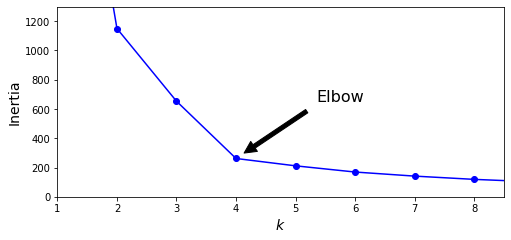

In [25]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

The inertia decreases as $k$ increases, but at a decreasing rate.

The curve has roughly the shape of an arm, with the '*elbow*' at $k=4$. So $k=4$ would be a good choice. Any higher value of $k$ does not help much.

We can be more precise and use the *silhouette score*, which is the mean *silhouette coefficient* over all the instances.

An instances silhouette coefficient is equal to:

$$\frac{(b-a)}{\max(a, b)}$$

where $a$ is the mean distance to the other instances in the same cluster (the mean intra-cluster distance), and $b$ is the mean nearest-cluster distance (the mean distance to the instances of the next closest cluster.)

The silhouette score varies between -1 and +1. A coefficient close to +1 means that the instance is well inside it's own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary. A coefficient close to -1 means that the instance  may have been assigned to the wrong cluster.

In [26]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

We can plot the silhouette scores as a function of $k$:

In [27]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

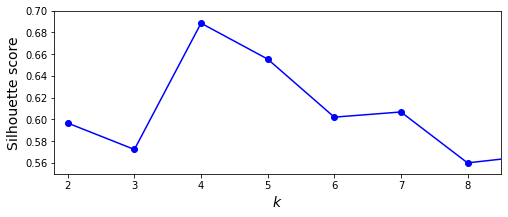

In [28]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

From the figure, $k=4$ is a good choice, but so is $k=5$. This was not visible when just comparing inertias.

We can plot a *silhouette diagram*, which plots every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient:

In [29]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

def plot_silhouette_diagram():
    for k in (3, 4, 5, 6):
        plt.subplot(2, 2, k - 2)

        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = plt.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (3, 5):
            plt.ylabel("Cluster")

        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)


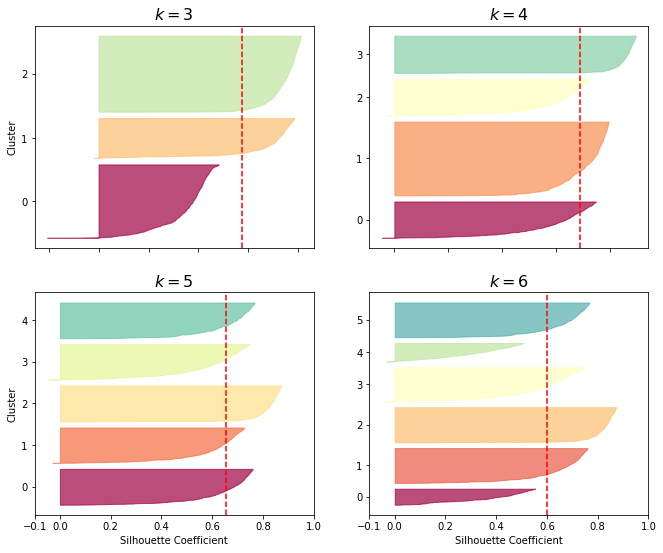

In [30]:
plt.figure(figsize=(11, 9))
plot_silhouette_diagram()
plt.show()

A shape's height indicates the number of instances in a cluster, the width represents the sorted silhouette coefficients of the instances in the cluster (wider is better).

The dashed line indicates the mean silhouette coefficient. When most of the instances in a cluster have a lower coefficient than this score, then the cluster is bad because too many instances are too close to other clusters.

### Limits of K-Means

- You must run the algorithm multiple times to avoid suboptimmal solutions.
- You need to specify the number of clusters which you might not know.
- K-Means does not behave well when the clusters have varying sizes, different densities, or nonspherical shapes.

Note: It's important to scale the input features to prevent clusters from being too stretched.

## Applications of Clustering

### Using Clustering for Image Segmantation

*Image segmentation* is the task of partitioning an image into multiple segments. There are multiple kinds of image segmentation:

- In *semantic segmentation*, all pixels that are part of the same object type are assigned to the same segment.
- In *instance segmentation*, all pixels that are part of the same individual object are assigned to the same segment.
- In *colour segmentation*, pixels of an image are assigned to the same segment if they have a similar colour.

If you want to, for example, analyse satellite images to measure how much total forest area there is in a region, color segmentation may be sufficient.

Let's load an image of a ladybug on a flower and perform colour segmentation using a K-Means clusterer:

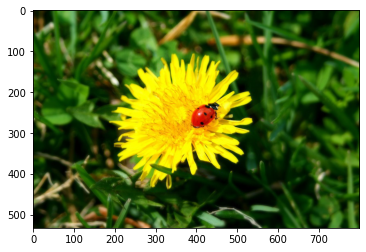

In [31]:
import os
from matplotlib.image import imread

images_path = os.path.join("Lecture19_Images", "ladybug.png")
image = imread(images_path)
plt.imshow(image)

The image is represented as a 3D array, where the first two dimension's size are the height and width of the image, and the third is the number of colour channels: in this case, red, green, and blue (RGB).

In other words, each pixel is a 3D vector containing the intensities of each of the RGB channels (from 0 to 255):

In [32]:
image.shape

(533, 800, 3)

First, we have to reshape the image into a long list of RGB colours, then we can train K-Means:

In [33]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

Then we convert each assigned label into an RGB value corresponding to the centroids, and reshape the array to have the same shape as the image:

In [34]:
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

Let's repeat this for for different numbers of clusters $k$ and show the resulting images:

In [35]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

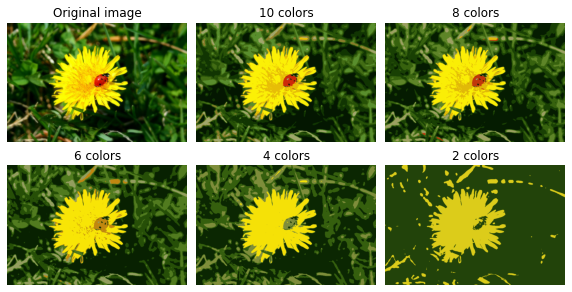

In [36]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

Note that for $k < 8$ the ladybug loses its bright colour. This is because K-Means prefers clusters of similar sizes: the ladybug makes up only a small number of pixels.

### Using Clustering for Preprocessing

You can use clustering as a preprocessing step analagous to dimensionality reduction.

Let's load the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images as 64D vectors, representing digits 0 to 9. Then let's split them into train and test sets:

In [37]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)
X_train.shape

(1347, 64)

Let's train a logistic regression model and evaluate it on the test set:

In [38]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Let's see if using K-Means as a preprocessing step improves the performance. We'll first cluster the training set into 50 clusters and replace the 64D image vectors with their distances to the 50 clusters:

In [39]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])

pipeline.fit(X_train, y_train)

pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

In [40]:
# Calculate the percentage drop in error rate
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

## DBSCAN

DBSCAN is a very simple algorithm that defines clusters as continuous regions of high density:

- For each instance, count how many instances are located within a small distance $\epsilon$ from it (this region is called the instances *$\epsilon$-neighborhood*).
- If an instance has at least `min_samples` instances in its $\epsilon$-neighborhood (including itself), then it is ocnsidered a *core instance* (i.e. one located in a dense region).
- All instances in the neighborhood of a core instance belong to the same cluster.
- Any instance that is not a core instance and does not have one in it's neighborhood is considered an *anomaly*.
- Sequences of neighboring core instances form a single cluster.

DBSAN works well if all clusters are dense enough and separated by low-density regions.
However, if the density varies significantly accross clusters, then it can be impossible to properly capture them.

Unlike K-Means, you don't have to specify the number of clusters: the `DBSCAN` class has only two hyperparameters.

Let's create a dataset using the `sklearn.make_moons()` function, and train a DBSCAN clusterer:

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [42]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Some labels have value `-1` which indicates anomalies.

We can widen each instances neighborhood by increasing `eps` to `0.2`. We can the compare the results to `eps=0.05`.

In [43]:
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [44]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

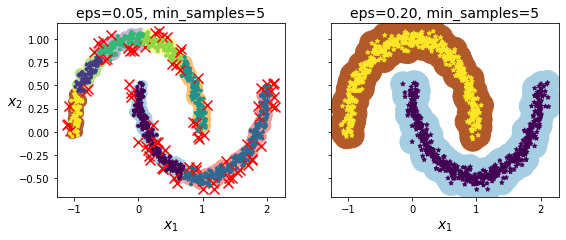

In [45]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

`eps=0.05` identifies seven clusters and quite a lot of anomalies, whereas `ebs=0.2` gives us a much better result.

## Gaussian Mixtures

A *Gaussian mixture model* (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of a number of Gaussian distributions whose parameters are unknown.

Instances generated from a Gaussian distribution form clusters that look like ellipsoids. Each cluster can have a different ellipoidal shape, size, density, and orientation.

Scikit-Learn contains several GMM variants. In the simplist, the `GaussianMixture` class, you must know in advance the number of Gaussian distributions $k$.

The dataset $\mathbf{X}$ is assumed to have been generated through the following probabilistic process:

- For each instance, a cluster is picked randomly from among $k$ clusters. The probability of choosing the $j^{\text{th}}$ cluster is defined by the clusters weight, $\phi^{(j)}$. The index of the cluster chosen for the $i^{\text{th}}$ instance is noted as $z^{(i)}$.
- If $z^{(i)}=j$, meaning the $i^{\text{th}}$ instance has been assigned to the $j^{\text{th}}$ cluster, the location $\mathbf{x}^{(i)}$  of this instance is sampled randomly from the Gaussian distribution with mean $\mathbf{\mu}^{(j)}$ and covariance matrix ${\sum}^{(j)}$. This is noted as:

$$\mathbf{x}^{(i)} \sim \mathcal{N} \left( \mathbf{\mu}^{(j)}, {\sum}^{(j)} \right)$$

This process can be represented as a graphical model.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/GNN.png" width="500px"/>
<!-- ![](https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture19_Images/GNN.png) -->

Here:

- The circles represent random variables.
- The squares represent fixed values (i.e., parameters of the model).
- The large rectangles are called *plates*, and indicate that their content is repeated several times.
- The number at the bottom right of each plate indicates how many times its content is repeated.
- Shaded nodes indicate known values. In this case, only the random variables $\mathbf{x}^{(i)}$ have known values: they are called *observed variables*. The unknown random variables $z^{(i)}$ are called *latent* variables.
- The solid arrows represent conditional dependencies. When an arrow crossses a plate boundary, it means that it applies to all the repetitions of that plate.

So there are $m$ random variables $z^{(i)}$ (from $z^{(1)}$ to $z^{(m)}$) and $m$ random variables $\mathbf{x}^{(i)}$. There are also $k$ means $\mathbf{\mu}^{(j)}$ and $k$ covariance matrices ${\sum}^{(j)}$. Lastly there is one weight vector $\mathbf{\phi}$ (containing all the weights $\phi^{(1)}$ to $\phi^{(k)}$).

Each variable $z^{(i)}$ is drawn from the *categorical distribution* with weights $\mathbf{\phi}$. Each variable $\mathbf{x}^{(i)}$ is drawn from the normal distribution, with the mean and covariance matrix defined by its cluster $z^{(i)}$.

Typically, given the dataset $\mathbf{X}$, you want to start by estimating the weights $\mathbf{\phi}$ and all the distribution parameters $\mathbf{\mu}^{(j)}$ and ${\sum}^{(j)}$.

Let's generate some data and train a GMM with 3 components:

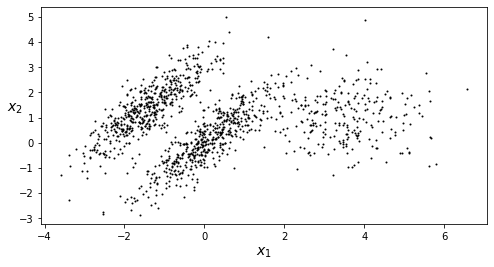

In [46]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plt.figure(figsize=(8, 4))
plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

In [47]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

We can then look at the parameters the model estimated:

In [48]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [49]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [50]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

### How does the GMM algorithm work?

The `GaussianMixture` class relies on the *Expectation-Maximisation* (EM) algorithm, which is is similar to the K-Means algorithm:

- First, randomly initialise the clusters.
- Then repeat until convergence:
    - Assign instances to clusters (the *expectation step*).
    - Update the clusters (the *maximisation step*).

You can think of EM as a generalisation of K-Means that not only finds the cluster centers ($\mathbf{\mu}^{(j)}$), but also their size, shape, and orientation (${\sum}^{(j)}$), as well as their relative weights ($\mathbf{\phi}$).

Unlike K-Means, EM uses soft clustering.

During the expectation step, the algorithm estimates the probability that each instance belongs to each cluster. Then, during the maximisation step, each cluster is updated using *all* the instances in the dataset, with each instance weighted by the estimated probability that it belongs to that cluster. These probabilities are called the *responsabilites* of the clusters for the instances.

Just like K-Means, EM can end up converging to poor solutions, so it needs to be run several times, keeping only the best one. This is done by setting `n_init`. Here we set it to `10`, but **be careful**: by default `n_init=1`.

You can check if the algorithm converged and how many iterations it took:

In [51]:
gm.converged_

True

In [52]:
gm.n_iter_

4

We can now use the model to assign each instance to clusters (hard clustering) or estimate the probability that it belongs to a particular cluster (soft clustering):

In [53]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [54]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

GMMs are *generative models*: you can sample new instances from them.

Note that the generated samples are ordered by cluster index:

In [55]:
X_new, y_new = gm.sample(6)

In [56]:
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [57]:
y_new

array([0, 0, 1, 2, 2, 2])

You can also estimate the density of the model at any given location.

The `score_samples()` method the returns the log of the *probability density function* (PDF) at the location of each instance it is given.

The greater the score, the higher the density.

In [58]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's plot the data, the cluster means, the decision boundaries (dashed lines), and the density contours of the model:

In [59]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

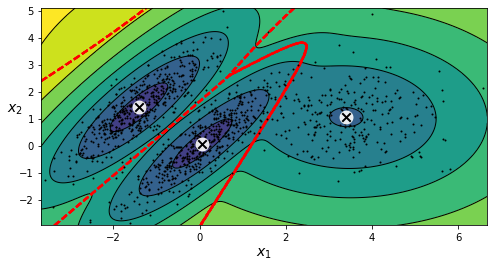

In [60]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

When there are many dimensions, clusters, or instances, EM can stuggle to converge.

The computational complexity of training a `GaussianMixture` model scales as either $O(kmn)$ or $O(kmn^2 + kn^3)$ depending on the `covariance_type`, so it will not scale to a large numbers of features.

In order to improve convergence, and/or the computational complexity, you might have to limit the difficulty of the learning task by reducing the number of parameters. One way of doing this is to limit the range of shapes and orientations that the clusters can have, which can be done by imposing constraints on the covariance matrices.

To do this, set the `covariance_type` hyperparameter to:

- `"spherical"`: all clusters must be sperical.
- `"diag"`: the ellipsoid's axes must be parallel to the coordinate axes (i.e., the covariance matrices must be diagonal).
- `"tied"`: all clusters must have the same ellipsoidal shape, size, and orientation (i.e., all clusters share the same covariance matix).

In [61]:
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)

gm_spherical.fit(X)
gm_diag.fit(X)
gm_tied.fit(X)

GaussianMixture(covariance_type='tied', n_components=3, n_init=10,
                random_state=42)

In [62]:
def compare_gaussian_mixtures(gm1, gm2, gm3, X):
    plt.subplot(131)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(132)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)
    
    plt.subplot(133)
    plot_gaussian_mixture(gm3, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm3.covariance_type), fontsize=14)

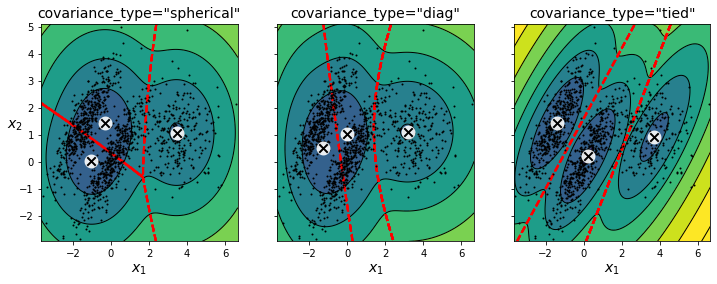

In [63]:
plt.figure(figsize=(12, 4))
compare_gaussian_mixtures(gm_spherical, gm_diag, gm_tied, X)
plt.show()

### Anomaly Detection Using Gaussian Mixtures

*Anomaly detection* (or *outlier detection*) is the task of detecting instances that deviate strongly from the norm, called *anomalies* or *outliers*.

It is useful in a range of appliactions, such as fraud detection, detectiong defective products, or rempving outliers from a dataset before training another model.

When using a GMM for anomaly detection, any instance located in a low density region can be considered an anomaly.

You must define a density threshold, below which instances are considered anomalies.

If there are too many false positives (i.e., instances that are flagged as anomalies but are not) then you can lower the threshold, and if there are too many false negatives (i.e., instances that are not flagged as anomalies but are) you can increase the threshold.

This is the usual precision/recall trade-off.

Using the same dataset as above, let's define the threshold as the fourth percentile lowest density, and plot the anomalies:

In [64]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

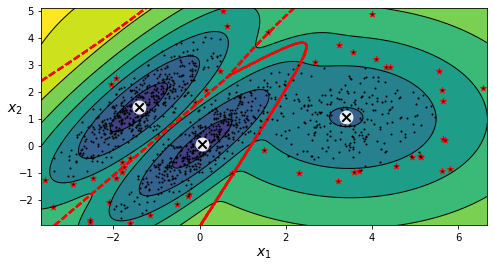

In [65]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

### Selecting the Number of Clusters

Like K-Means, the `GaussianMixture` algorithm require you to specify the number of clusters.

Unlike with K-Means, you cannot use the inertia or the silhouette score to select the appropriate number of clusters, as they are not reliable when the clusters are not sperical or have different sizes.

Instead, you can try to find a model that minimizes a *theoretical information criterion*, such as the *Bayesian information criterion* (BIC) or the *Akaike information criterion* (AIC).

The Bayesian information criterion (BIC) and the Akaike information criterion (AIC) are given by

$$BIC = \log (m)p - 2 \log \left(\hat{L}\right)$$

and

$$AIC = 2p - 2 \log \left(\hat{L}\right)$$

where $m$ is the number of instances, $p$ is the number of parameters learned by the model, and $\hat{L}$ is the maximised value of the *liklihood function* of the model. This is the conditional probability of the observed data $\mathbf{X}$ given the model, and its optimised parameters.

Both the BIC and AIC penalise models that have more parameters (e.g., more clusters) and reward models that fit the data well.

The model selected by the BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but tends not to fit the data quite as well (this is especially true for large datasets).

Consider again the model trained on the dataset above. We can call the models `bic()` and `aic()` methods to get the BIC and AIC:

In [66]:
gm.bic(X)

8189.747000497188

In [67]:
gm.aic(X)

8102.52172038215

Let's train GMMs with a range of values of $k$ and measure their BICs and AICs:

In [68]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [69]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

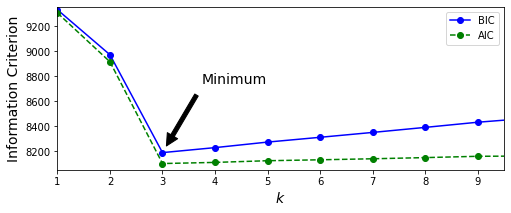

In [70]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

### Bayesian Gaussian Mixture Models

Instead of manually searching for the optimal number of clusters, you can use the `BayesianGaussianMixture` class, which sets weights equal (or close) to zero for unnecessary clusters.

Set the number of clusters `n_components` to a value that you estimate, and the algorithm will eliminate unnecessary clusters.

In [71]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [72]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

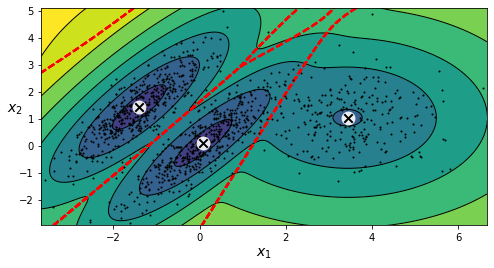

In [73]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(bgm, X)
plt.show()

In this model, the cluster parameters are not treated as fixed values, but as latent random variables. So now $\mathbf{z}$ includes both the cluster parameters and the cluster assignments.

Prior knowledge about the latent variables can be encoded in a probability distribution called the *prior*. This can be adjusted using the `weight_concentration_prior` hyperparameter.

For example, we may have a prior belief that there are likely to be few clusters (low concentration), or that there are likely to be many clusters (high concentration)

Let's train a `BayesianGaussianMixture` model with low and high priors and compare their results:

In [74]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [75]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [76]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

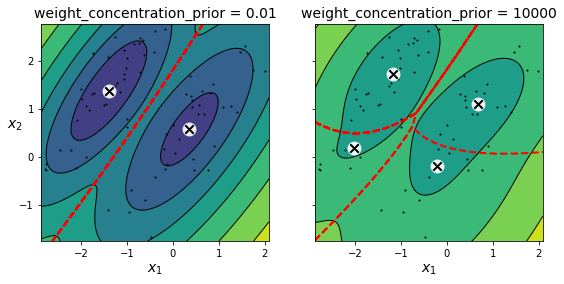

In [77]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

## Other Algorithms in SciKit-Learn for Clustering and Anomaly Detection

Scikit-Learn contains a number of algorithms for clustering and anomaly detection, such as:

- Agglomerative clustering
- Spectral clustering
- Isolation Forest
- One-class SVM

Check out the [Scikit-Learn documentation on unsupervised learning](https://scikit-learn.org/stable/unsupervised_learning.html) for more information.